<a href="https://colab.research.google.com/github/swardiantara/fp-kk-2021/blob/main/Named_Entity_Recognition_v1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
#import the required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from numpy.random import seed
from itertools import chain
from tensorflow.keras import Model,Input
from tensorflow.keras.layers import LSTM,Embedding,Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D,Bidirectional
plt.style.use('seaborn')

In [50]:
#Mount the G Drive to access the data set
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [51]:
dataset_path = '/content/drive/MyDrive/Colab Notebooks/ner-kk/ner_datasetreference.csv'
data=pd.read_csv(dataset_path,encoding='unicode_escape')
data.head()

,Sentence #,Word,POS,Tag,Class
0,Sentence: 1,Thousands,NNS,O,0
1,NaN,of,IN,O,0
2,NaN,demonstrators,NNS,O,0
3,NaN,have,VBP,O,0
4,NaN,marched,VBN,O,0


In [52]:
#Delete the POS column as we do not need it
data.drop('POS',axis='columns',inplace=True)

In [53]:
data.head(15)

,Sentence #,Word,Tag,Class
0,Sentence: 1,Thousands,O,0
1,NaN,of,O,0
2,NaN,demonstrators,O,0
3,NaN,have,O,0
4,NaN,marched,O,0
5,NaN,through,O,0
6,NaN,London,B-geo,1
7,NaN,to,O,0
8,NaN,protest,O,0
9,NaN,the,O,0


In [54]:
#NaN values to be filled using Forward Fill method.
data=data.fillna(method='ffill')

In [55]:
data.head(35)

,Sentence #,Word,Tag,Class
0,Sentence: 1,Thousands,O,0
1,Sentence: 1,of,O,0
2,Sentence: 1,demonstrators,O,0
3,Sentence: 1,have,O,0
4,Sentence: 1,marched,O,0
5,Sentence: 1,through,O,0
6,Sentence: 1,London,B-geo,1
7,Sentence: 1,to,O,0
8,Sentence: 1,protest,O,0
9,Sentence: 1,the,O,0


In [56]:
words=list(set(data['Word'].values))
words.append("ENDPAD")
words[-1]

'ENDPAD'

In [57]:
#Total no. of words
num_words = len(words)
print("Total number of words", num_words)

Total number of words 35172


In [58]:
#List of Tags and total no. of Tags
tags = list(set(data["Tag"].values))
num_tags = len(tags)
num_tags
print("List of tags: " + ', '.join([tag for tag in tags]))
print(f"Total Number of tags {num_tags}")

List of tags: I-nat, B-art, B-tim, I-art, I-org, I-per, B-per, B-org, I-geo, B-nat, O, I-gpe, I-tim, B-geo, B-eve, I-eve, B-gpe
Total Number of tags 17


In [59]:
data.head()

,Sentence #,Word,Tag,Class
0,Sentence: 1,Thousands,O,0
1,Sentence: 1,of,O,0
2,Sentence: 1,demonstrators,O,0
3,Sentence: 1,have,O,0
4,Sentence: 1,marched,O,0


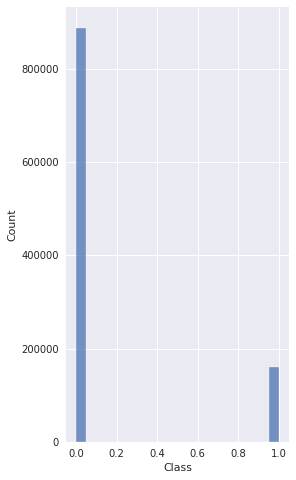

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (4,8))
sns.set_style('darkgrid')
sns.histplot(data['Class'])
plt.show()

In [14]:
#Creating a Class which will give the complete sentence with Tags attached with each word
class Get_sentence(object):
  def __init__(self,data):
    self.n_sent=1
    self.data=data
    agg_func=lambda s:[(w,t) for w,t in zip(s['Word'].tolist(),s['Tag'].tolist())]
    self.grouped=self.data.groupby('Sentence #').apply(agg_func)
    self.sentences=[s for s in self.grouped]

In [15]:
getter=Get_sentence(data)
sentence=getter.sentences

In [25]:
sentence[0]

[('Thousands', 'O'),
 ('of', 'O'),
 ('demonstrators', 'O'),
 ('have', 'O'),
 ('marched', 'O'),
 ('through', 'O'),
 ('London', 'B-geo'),
 ('to', 'O'),
 ('protest', 'O'),
 ('the', 'O'),
 ('war', 'O'),
 ('in', 'O'),
 ('Iraq', 'B-geo'),
 ('and', 'O'),
 ('demand', 'O'),
 ('the', 'O'),
 ('withdrawal', 'O'),
 ('of', 'O'),
 ('British', 'B-gpe'),
 ('troops', 'O'),
 ('from', 'O'),
 ('that', 'O'),
 ('country', 'O'),
 ('.', 'O')]

In [ ]:
### Data Visualizaion

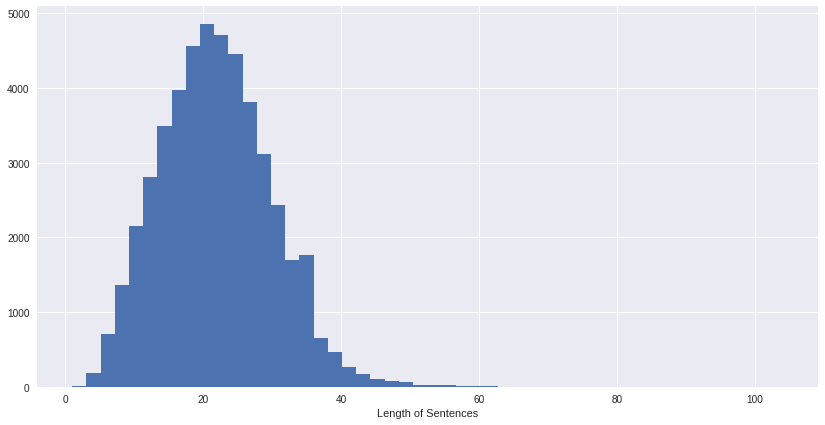

In [17]:
plt.figure(figsize=(14,7))
plt.hist([len(s) for s in sentence],bins = 50)
plt.xlabel("Length of Sentences")
plt.show()

In [ ]:
# most of our sentenses have a length of 20 words, the longest sentense is around 63 words



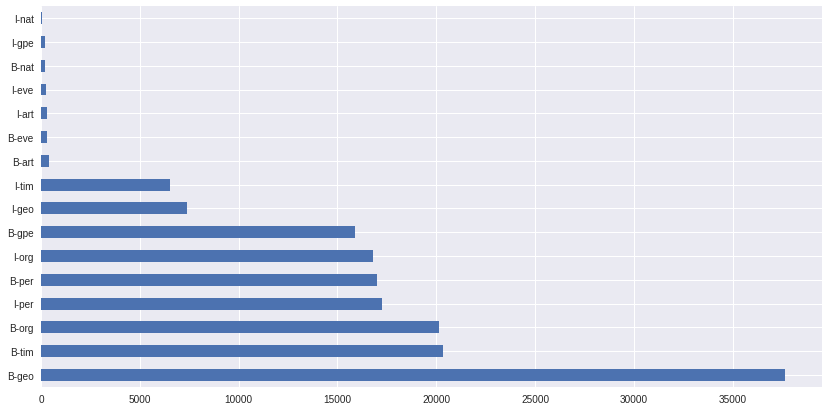

In [18]:
plt.figure(figsize=(14, 7))
data.Tag[data.Tag != 'O']\
    .value_counts()\
    .plot\
    .barh();

In [ ]:
## We can understand from the bar chart above that B-geo Tags are over-represented. 
## I-nat and I-gpe Tags are negligible and almost non-existent. Model will have difficulty in classifying these 2 tags.

In [ ]:
# Data Preparation

In [26]:
word_idx = {w : i + 1 for i ,w in enumerate(words)}
tag_idx =  {t : i for i ,t in enumerate(tags)}

In [27]:
word_idx['Dniester']

25624

In [30]:
# Padding our sentences using max lenght of 50.
max_len=50
X=[[word_idx[w[0]] for w in s] for s in sentence]
X=pad_sequences(maxlen=max_len,sequences=X,padding='post',value=num_words-1)
y=[[tag_idx[w[1]]for w in s]for s in sentence]
y=pad_sequences(maxlen=max_len,sequences=y,padding='post',value=tag_idx['O'])


In [31]:
X[0]

array([30795, 29134, 10313,  8144,  4448, 24525,  4286,  8368,  5714,
       19384,  4496, 16595, 10723, 29619, 20024, 19384, 19156, 29134,
       14311, 22994, 28043, 10816,  1834, 12728, 35171, 35171, 35171,
       35171, 35171, 35171, 35171, 35171, 35171, 35171, 35171, 35171,
       35171, 35171, 35171, 35171, 35171, 35171, 35171, 35171, 35171,
       35171, 35171, 35171, 35171, 35171], dtype=int32)

In [32]:
y[0]

array([10, 10, 10, 10, 10, 10, 13, 10, 10, 10, 10, 10, 13, 10, 10, 10, 10,
       10, 16, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
      dtype=int32)

In [33]:
y=[to_categorical(i,num_classes=num_tags) for i in y]

In [34]:
num_tags

17

In [35]:
y[0]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0

In [36]:
# Split the data using Train Test split.
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.1,random_state=1)

In [ ]:
# Building the model

In [37]:
input_word=Input(shape=(max_len,))
model=Embedding(input_dim=num_words,output_dim=max_len,input_length=max_len)(input_word)
model=SpatialDropout1D(0.1)(model)
model=Bidirectional(LSTM(units=100,return_sequences=True,recurrent_dropout=0.1))(model)
out=TimeDistributed(Dense(num_tags,activation='softmax'))(model)
model=Model(input_word,out)

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 50)            1758600   
                                                                 
 spatial_dropout1d (SpatialD  (None, 50, 50)           0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 50, 200)          120800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 50, 17)           3417      
 ibuted)                                                         
                                                             

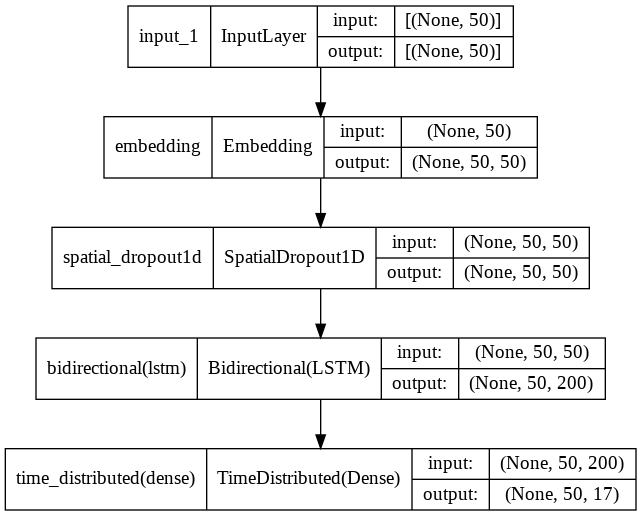

In [38]:
plot_model(model,show_shapes=True)

In [40]:
#Training the model with Training data
his = model.fit(X_train,np.array(y_train),batch_size=64,verbose=1,epochs=3,validation_split=0.2)

Epoch 1/3
540/540 [==============================] - 146s 270ms/step - loss: 0.1295 - accuracy: 0.9622 - val_loss: 0.0786 - val_accuracy: 0.9784
Epoch 2/3
540/540 [==============================] - 145s 269ms/step - loss: 0.0598 - accuracy: 0.9830 - val_loss: 0.0555 - val_accuracy: 0.9833
Epoch 3/3
540/540 [==============================] - 145s 269ms/step - loss: 0.0435 - accuracy: 0.9872 - val_loss: 0.0511 - val_accuracy: 0.9846


In [42]:
import tensorflow as tf
tf.keras.models.save_model(model, filepath  = "/content/drive/MyDrive/Colab Notebooks/ner-kk/bilstm-2_model_baseline.h5")

In [ ]:
# Model Evaluation

In [43]:
model.evaluate(X_test,np.array(y_test))

150/150 [==============================] - 5s 30ms/step - loss: 0.0529 - accuracy: 0.9845


[0.05290699377655983, 0.9844661951065063]

In [48]:
# Model Prediction with Test set
rand_sent=np.random.randint(0,X_test.shape[0])
p=model.predict(np.array([X_test[rand_sent]]))
p=np.argmax(p,axis=-1)

y_true=np.argmax(np.array(y_test),axis=-1)[rand_sent]

print("{:20}{:20}\t{}\n".format("Word","True","Pred"))
print("-"*55)

for (w,t,pred)in zip(X_test[rand_sent],y_true,p[0]):
  print("{:20}{:20}\t{}".format(words[w-1],tags[t],tags[pred]))

Word                True                	Pred

-------------------------------------------------------
During              O                   	O
his                 O                   	O
trip                O                   	O
,                   O                   	O
the                 O                   	O
pope                O                   	O
repeatedly          O                   	O
referred            O                   	O
to                  O                   	O
the                 O                   	O
sexual              O                   	O
abuse               O                   	O
scandal             O                   	O
that                O                   	O
has                 O                   	O
wracked             O                   	O
the                 O                   	O
U.S.                B-geo               	B-geo
church              O                   	O
.                   O                   	O
MBEKI               O            